Cash Flow for Hardy + Risky SOSI

1. Read the best PNL values
Read the best stop loss and target profit values for NIFTY, BANKNIFTY, and FINNIFTY from a file.
2. Filter buy signals
From the 15-minute chart data, filter out buy signals that are original buy signals and not short signals.
3. Calculate charges
Define a function to calculate the charges for a trade including brokerage, STT/CTT, transaction charges, GST, SEBI charges, and stamp charges.
4. Simulate all trades
For each buy signal, determine the entry price and calculate the profit price and stop price.
Determine the exit time and price based on subsequent data for the same day.
Calculate the profit or loss for the trade and append it to the results.
5. Simulate live trading account
Initialize the account with the initial balance.
Iterate through each second from the earliest entry time to the latest exit time.
For each second, handle exiting trades first by adding their profit or loss back to the account balance.
Then, handle entering trades by checking if the account balance is sufficient to cover the trade cost. If not, mark the trade as missed.
Keep track of the daily balance, executed trades, and missed trades.
6. Process each directory
For each directory (NIFTY, BANKNIFTY, FINNIFTY), load the 15-minute chart data, filter buy signals, and simulate all trades using the best PNL values.
7. Combine all trades
Combine all trades from different indexes into a single DataFrame and sort by entry time.
8. Simulate live trading account
Use the combined trades to simulate the live trading account and get the daily balance, missed trades, and executed trades.
9. Save results and generate visualizations
Save the combined trades, daily balance, missed trades, and executed trades to CSV files.
Generate visualizations for the daily balance, worst trade, best trade, max drawdown, highest balance, count of missed trades, histogram of trade profits, pie chart of trade outcomes, and summary statistics.
This approach ensures that the simulation takes into account the initial capital and handles trades in a realistic manner, updating the account balance as trades are


Processing NSE_NIFTY240620C23400, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23400, 1.csv. Skipping...
Processing NSE_NIFTY240620C23500, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23500, 1.csv. Skipping...
Processing NSE_NIFTY240620C23550, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23550, 1.csv. Skipping...
Processing NSE_NIFTY240620C23600, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23600, 1.csv. Skipping...
Processing NSE_NIFTY240620P23400, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23400, 1.csv. Skipping...
Processing NSE_NIFTY240620P23500, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23500, 1.csv. Skipping...
Processing NSE_NIFTY240620P23550, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23550, 1.csv. Skipping...
Processing NSE_NIFTY240620P23600, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23600, 1.csv. Skipping...
Processing NSE_NIFTY240627C23300, 1.csv in NIFTY

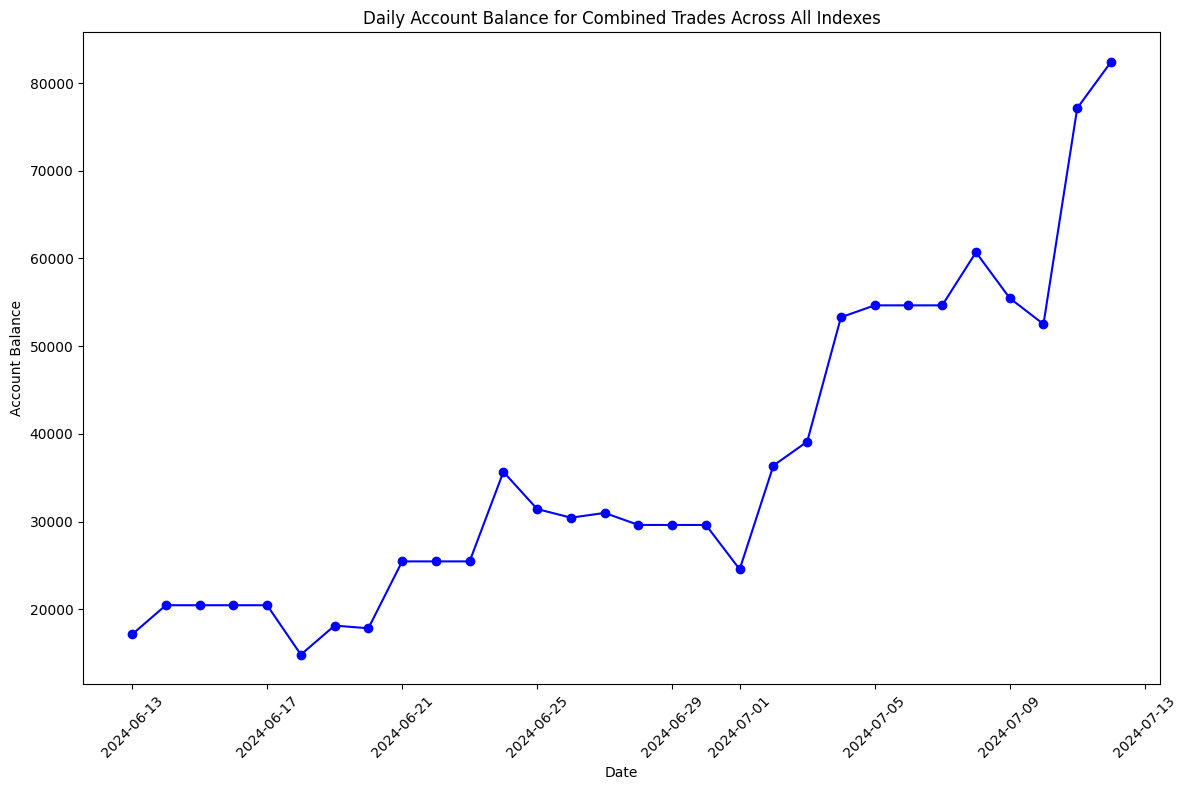

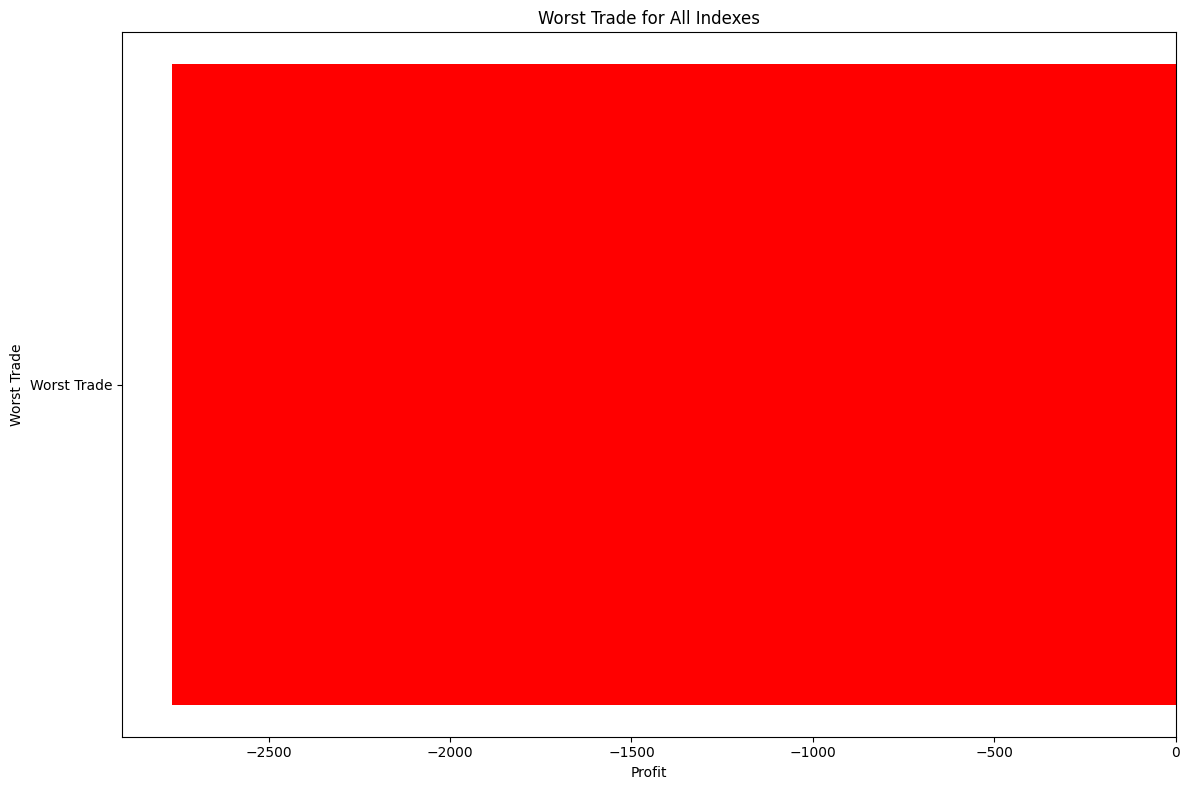

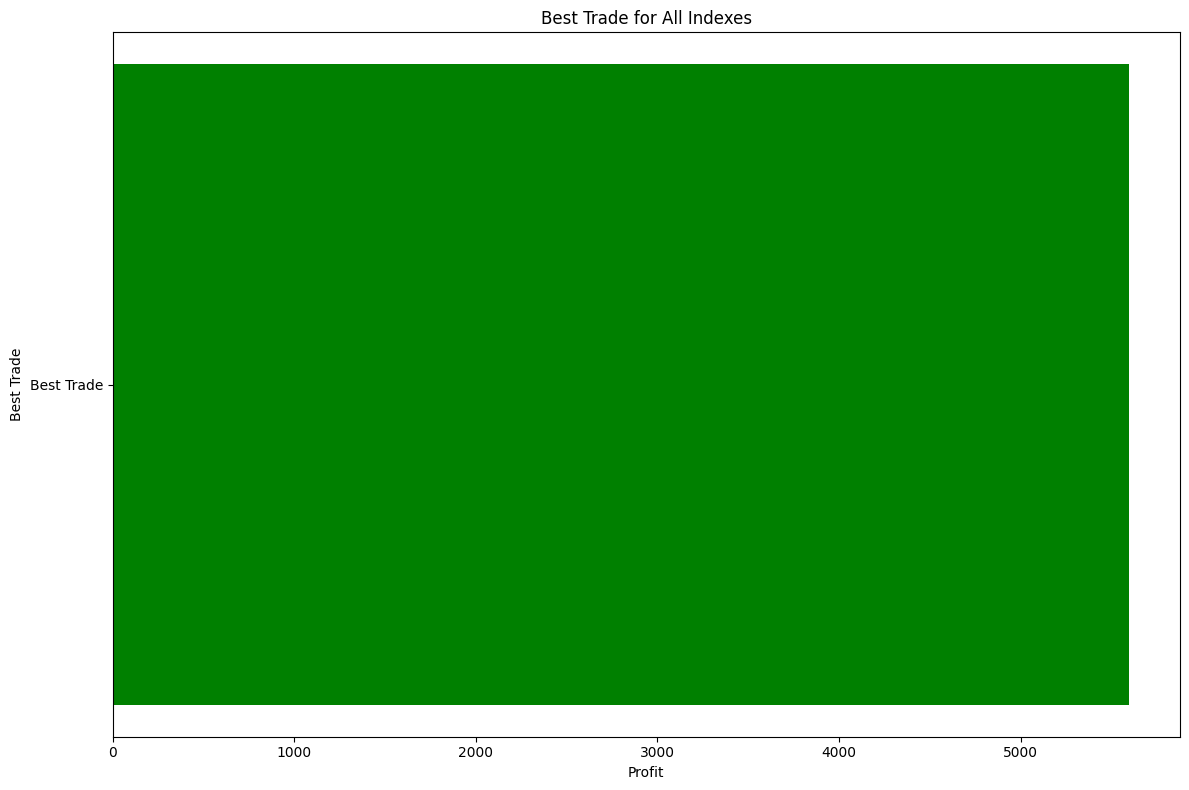

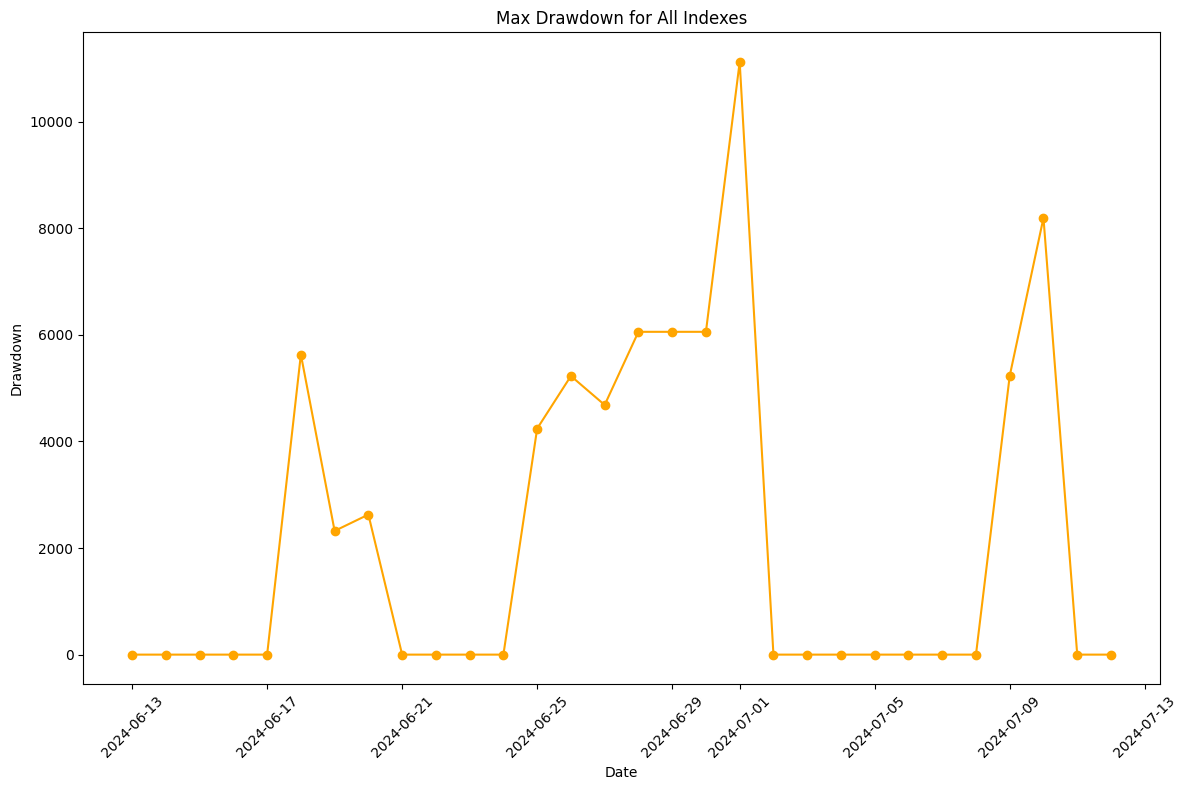

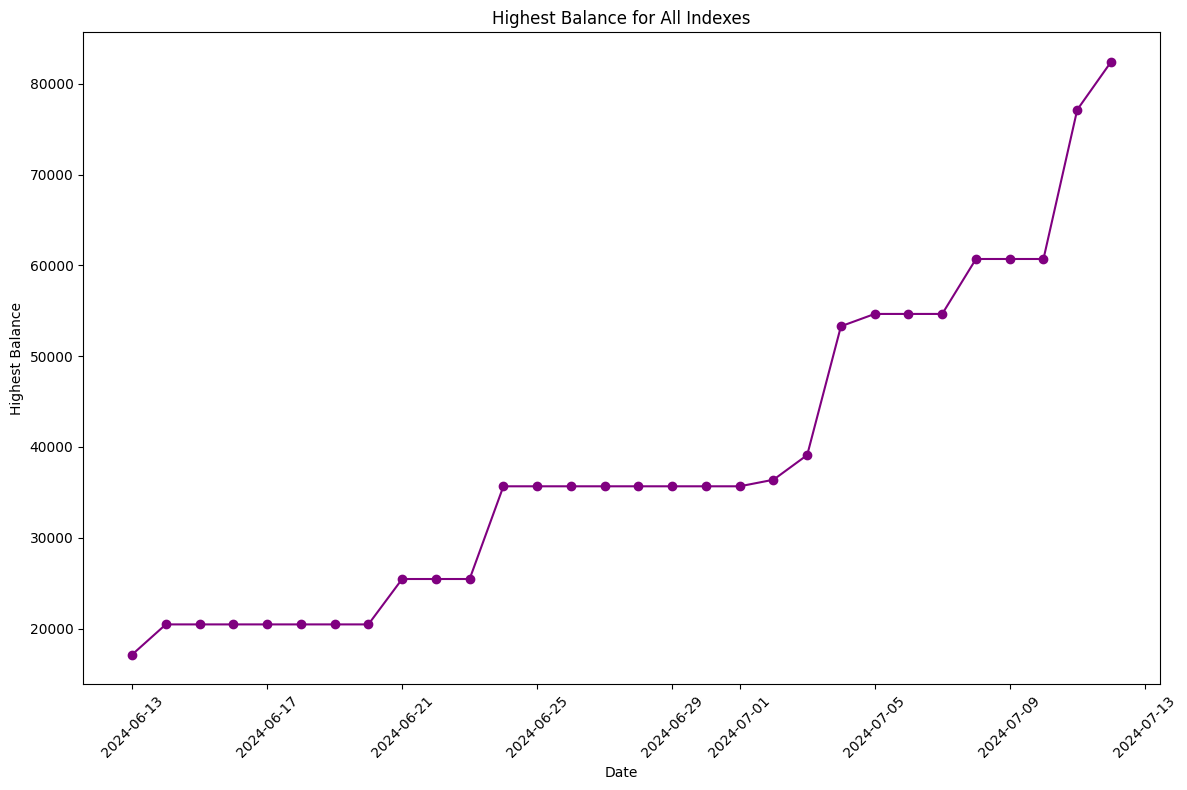

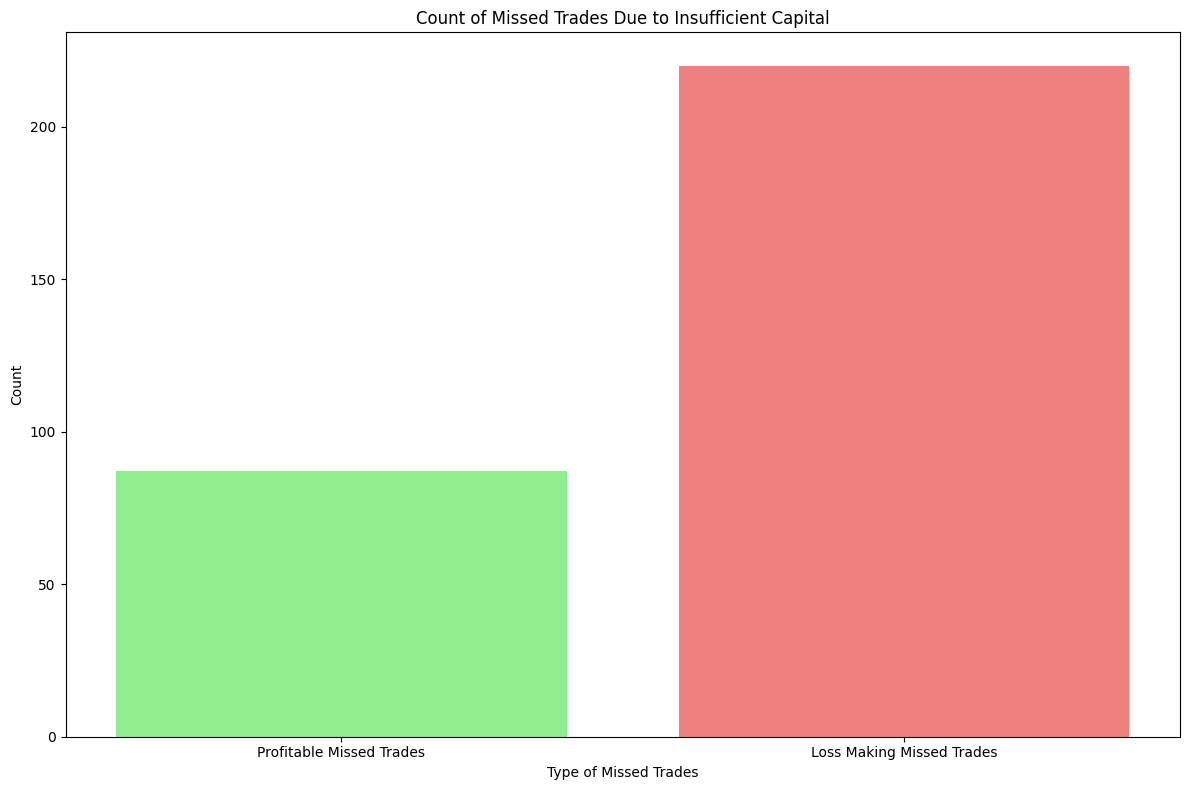

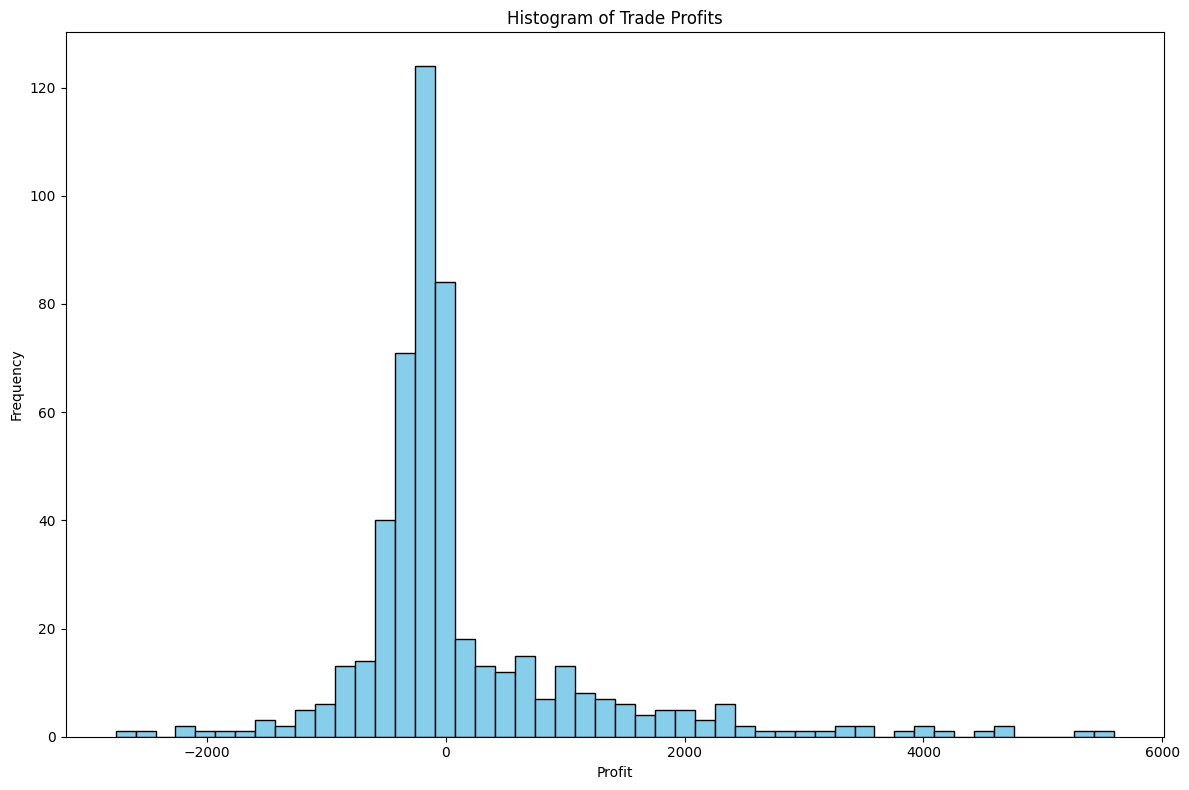

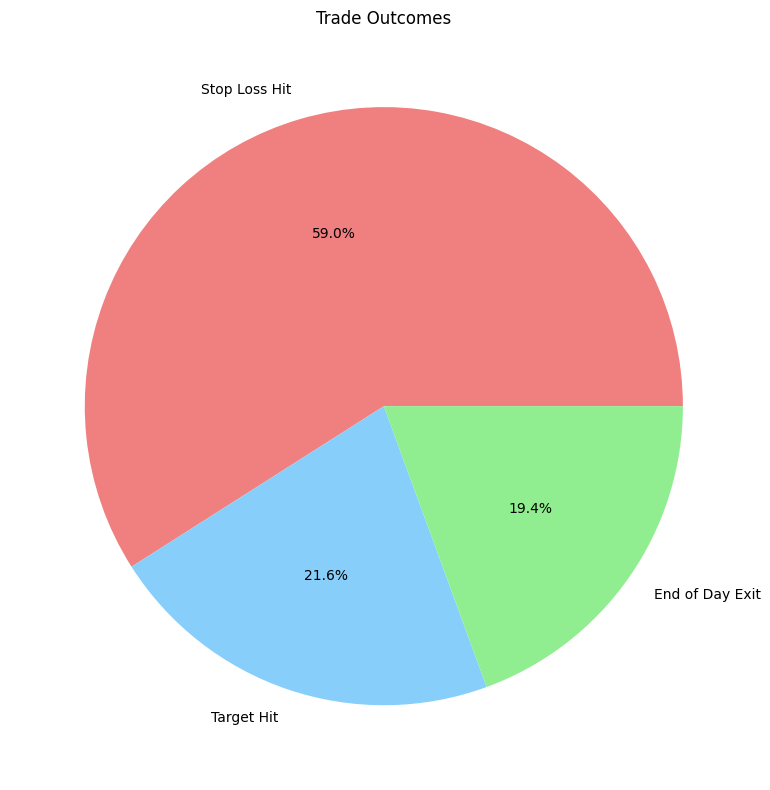

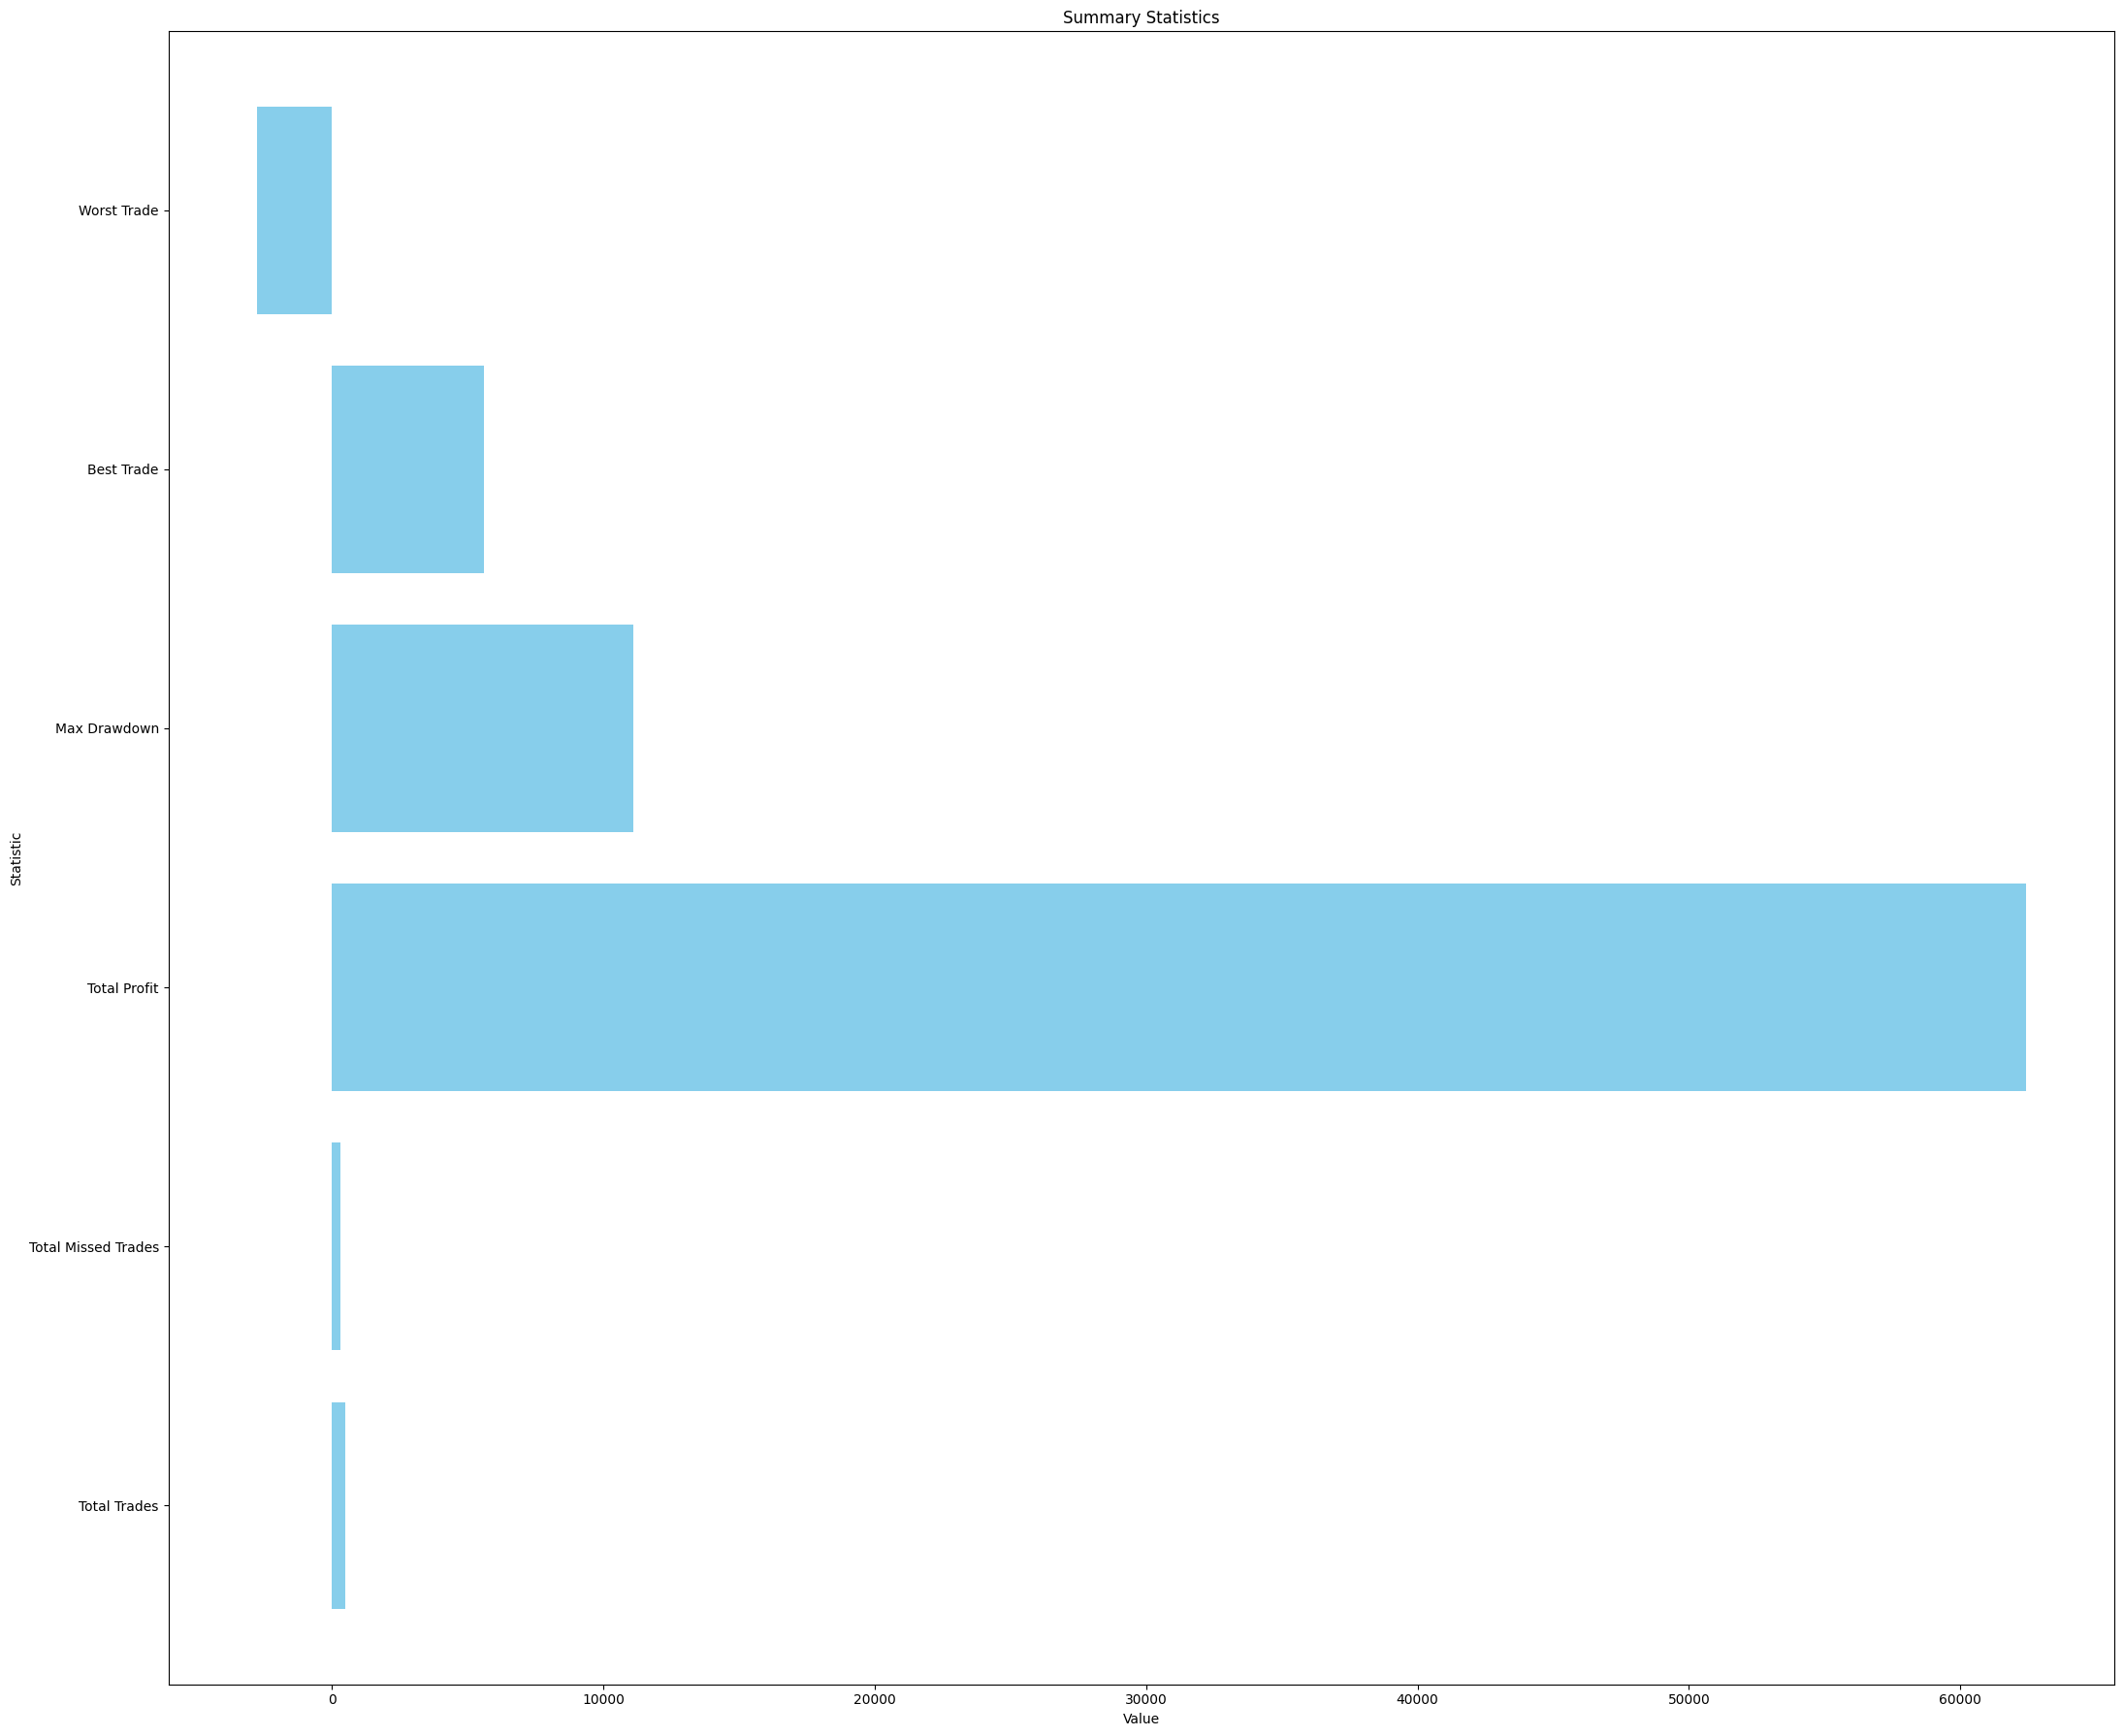

Final summary statistics:
   Total Trades  Total Missed Trades  Total Profit  Max Drawdown   Best Trade  \
0           510                  307  62411.182273   11120.93298  5597.743122   

   Worst Trade  
0 -2766.817233  
Final Balance: 82411.18227267003
Max Drawdown: 11120.932979936239
Best Trade: 5597.743122292502
Worst Trade: -2766.8172329999993
Total Trades: 510
Total Missed Trades: 307
Total Profit: 62411.182272670005
Total Profitable Trades: 151
Analysis and visualization complete.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

# Function to read best PNL combinations from a file
def read_best_pnl(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        best_pnl_values = {
            'NIFTY': {'stop_loss': float(lines[14].strip()), 'target': float(lines[15].strip())},
            'BANKNIFTY': {'stop_loss': float(lines[16].strip()), 'target': float(lines[17].strip())},
            'FINNIFTY': {'stop_loss': float(lines[18].strip()), 'target': float(lines[19].strip())}
        }
    return best_pnl_values

# Function to read best PNL combinations from a file
def read_best_pnl_Hardy(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        best_pnl_values = {
            'NIFTY': {'stop_loss': float(lines[0].strip()), 'target': float(lines[1].strip())},
            'BANKNIFTY': {'stop_loss': float(lines[2].strip()), 'target': float(lines[3].strip())},
            'FINNIFTY': {'stop_loss': float(lines[4].strip()), 'target': float(lines[5].strip())}
        }
    return best_pnl_values


# Function to calculate indicators and buy signals
def calculate_indicators(data):
   
    # Calculate VWPCI
    if 'volume' in data.columns:
        volume = data['volume']
    elif 'Volume' in data.columns:
        volume = data['Volume']
    data['priceChangeRatio'] = (data['close'] - data['open']) / (data['high'] - data['low'])
    data['VWPCI'] = data['priceChangeRatio'] * volume


    # Convert Unix timestamp (UTC) to datetime
    data['time_utc'] = pd.to_datetime(data['time'], unit='s', utc=True)

    # Convert UTC to IST
    data['time_ist'] = data['time_utc'] + timedelta(hours=5, minutes=30)

    # Calculate ROC
    roc_periods = 14
    data['ROC'] = data['close'].pct_change(periods=roc_periods)

    # Calculate MVI
    data['MVI'] = volume * ((data['close'] - data['open']) / data['close'])

    # Calculate VOLD
    data['up_volume'] = np.where(data['close'] > data['close'].shift(1), volume, 0)
    data['down_volume'] = np.where(data['close'] <= data['close'].shift(1), volume, 0)
    data['total_up_volume'] = data['up_volume'].cumsum()
    data['total_down_volume'] = data['down_volume'].cumsum()
    data['VOLD_ratio'] = data['total_up_volume'] / data['total_down_volume']

    # Normalize VOLD
    data['normalized_vold'] = (data['VOLD_ratio'] - data['VOLD_ratio'].rolling(window=100).min()) / \
                              (data['VOLD_ratio'].rolling(window=100).max() - data['VOLD_ratio'].rolling(window=100).min())

    # Theta Calculation
    days_to_expiration = 30  # assuming a constant value
    d1 = (np.log(data['close'] / data['close']) + (0.05 + (0.2 * 0.2) / 2) * days_to_expiration / 365) / (0.2 * np.sqrt(days_to_expiration / 365))
    d2 = d1 - 0.2 * np.sqrt(days_to_expiration / 365)
    theta_call = -(data['close'] * 0.2 * np.exp(-0.05 * days_to_expiration / 365) * (np.exp(-(d1 ** 2) / 2) / np.sqrt(2 * np.pi))) / \
                 (2 * np.sqrt(days_to_expiration / 365)) - 0.05 * 100 * np.exp(-0.05 * days_to_expiration / 365) * \
                 (np.exp(-(d2 ** 2) / 2) / np.sqrt(2 * np.pi))
    data['theta'] = theta_call

    # Normalize Theta
    data['normalized_theta'] = (data['theta'] - data['theta'].rolling(window=100).min()) / \
                               (data['theta'].rolling(window=100).max() - data['theta'].rolling(window=100).min())

    # Composite SOSI Calculation
    data['sosi_base'] = 0.1 * data['VWPCI'] + 0.2 * data['ROC'] + 0.3 * data['MVI']
    data['sosi'] = data['sosi_base'] + 0.4 * data['normalized_vold'] + 0.1 * data['normalized_theta']

    # Calculate slopes
    data['sosi_slope'] = data['sosi'] - data['sosi'].shift(1)
    data['vold_slope'] = data['normalized_vold'] - data['normalized_vold'].shift(1)

    # Define conditions
    data['condition1'] = (data['sosi'] < 0) & (data['sosi_slope'] > 0) & (data['normalized_vold'] < 0) & (data['vold_slope'] > 0) & (data['sosi'] < data['normalized_vold'])
    data['condition2'] = (data['sosi'] > 0) & (data['sosi_slope'] > 0) & (data['normalized_vold'] > 0) & (data['vold_slope'] > 0) & (data['sosi'] > data['normalized_vold'])
    data['condition3'] = (data['sosi'] < 0) & (data['sosi_slope'] > 0) & (data['sosi'].shift(1) < data['sosi'].shift(2)) & (data['normalized_vold'] < 0) & (data['vold_slope'] > 0) & (data['normalized_vold'].shift(1) < data['normalized_vold'].shift(2))
    data['condition4'] = (data['sosi_slope'] > 0) & (data['vold_slope'] > 0) & (data['sosi'] < data['normalized_vold'])

    # Combine conditions into the buy signal
    data['Buy Signal SOSI Final'] = (data['time_ist'].dt.time == pd.Timestamp('09:20:00').time()) & (data['condition1'] | data['condition2'] | data['condition3'] | data['condition4'])

    return data

# Function to filter buy signals from the 15-minute chart data
def filter_signals_Hardy(data):
    buy_signals = data[(data['Original Buy Signal'] == True) & (data['Short Signal'] == False)]
    return buy_signals


# Function to filter buy signals from the 1-minute chart data
def filter_signals(data):
    if 'Buy Signal SOSI Final' not in data.columns:
        print("Warning: 'Buy Signal SOSI Final' column not found in the data.")
        if 'volume' and 'Volume' not in data.columns:
            print("Error: 'volume' column not found in the data.")
            return pd.DataFrame()
        data=calculate_indicators(data)
        if 'Buy Signal SOSI Final' not in data.columns:
            print("Error: 'Buy Signal SOSI Final' column still not found in the data.")
            return pd.DataFrame()
        buy_signals = data[(data['Buy Signal SOSI Final'] == True)]
        return buy_signals
        

    buy_signals = data[(data['Buy Signal SOSI Final'] == True)]
    return buy_signals



# Function to calculate charges
def calculate_charges(entry_price, exit_price, quantity):
    brokerage = 40  # total brokerage for one complete buy and sell
    stt_ctt = 0.00125 * exit_price * quantity
    transaction_charges = 0.000495 * (entry_price + exit_price) * quantity
    gst = 0.18 * (brokerage + transaction_charges)
    sebi_charges = 10 / 10**7 * (entry_price + exit_price) * quantity
    stamp_charges = 0.00003 * entry_price * quantity
    total_charges = brokerage + stt_ctt + transaction_charges + gst + sebi_charges + stamp_charges
    return total_charges

# Function to simulate day trades with error margin
def simulate_day_trades(buy_signals, minute_data, symbol, profit_target=0.02, stop_loss=0.01, min_stop_loss=0.005, error_margin=0.01):
    results = []

    for index, buy_signal in buy_signals.iterrows():
        entry_price = buy_signal['close'] #* (1 + error_margin)  # Adjust entry price with error margin
        entry_time = buy_signal['time'] + 900  # Add 15 minutes to the buy signal time to get the entry time
        profit_price = entry_price * (1 + profit_target)
        stop_price = entry_price * (1 - max(stop_loss, min_stop_loss))  # Ensure stop loss is at least min_stop_loss
        
        trade_result = {
            'symbol': symbol,
            'signal_time': buy_signal['time'],
            'entry_time': entry_time,
            'entry_price': entry_price,
            'Target Profit': profit_target,
            'Stop Loss': stop_loss,
            'Profit Price': profit_price,
            'Stop Price': stop_price,
            'exit_time': None,
            'exit_price': None,
            'charges': None,
            'profit_before_charges': None,
            'profit': None,
            'exit_reason': None,
            'missed': False
        }
        
        # Filter subsequent data for the same day only
        trade_date = pd.to_datetime(entry_time, unit='s').date()
        subsequent_data = minute_data[(minute_data['time'] > entry_time) & 
                                      (pd.to_datetime(minute_data['time'], unit='s').dt.date == trade_date)]
      
        error_margin = 0  # Default error margin for 1-minute data

        if subsequent_data.empty:
            # Use 15-minute chart data if 1-minute data is empty
            subsequent_data = minute_data_15[(minute_data_15['time'] > entry_time) & 
                                             (pd.to_datetime(minute_data_15['time'], unit='s').dt.date == trade_date)]
            error_margin = 960  # Adjust error margin for 15-minute data
            
        for _, row in subsequent_data.iterrows():
            if row['high'] >= profit_price:
                trade_result['exit_time'] = row['time'] + error_margin
                trade_result['exit_price'] = profit_price
                trade_result['exit_reason'] = 'Target Hit'
                break
            if row['low'] <= stop_price:
                trade_result['exit_time'] = row['time'] + error_margin
                trade_result['exit_price'] = stop_price
                trade_result['exit_reason'] = 'Stop Loss Hit'
                break
        else:
            # If no target or stop loss hit, exit at the last price of the day (3:25 PM)
            end_of_day_time = pd.to_datetime(trade_date) + pd.Timedelta(hours=15, minutes=25)
            eod_exit_data = minute_data[(pd.to_datetime(minute_data['time'], unit='s') <= end_of_day_time)]
            
            if eod_exit_data.empty:
                eod_exit_data = minute_data_15[(pd.to_datetime(minute_data_15['time'], unit='s') <= end_of_day_time)]
            
            if not eod_exit_data.empty:
                last_row = eod_exit_data.iloc[-1]
                trade_result['exit_time'] = last_row['time'] + error_margin
                trade_result['exit_price'] = last_row['close']
                trade_result['exit_reason'] = 'End of Day Exit'
        
        if trade_result['exit_price'] is not None:
            quantity = 25 if 'NIFTY' in symbol else 15 if 'BANKNIFTY' in symbol else 40 if 'FINNIFTY' in symbol else 10
            gross_profit = (trade_result['exit_price'] - trade_result['entry_price']) * quantity
            charges = calculate_charges(trade_result['entry_price'], trade_result['exit_price'], quantity)
            net_profit = gross_profit - charges
            trade_result['charges'] = charges
            trade_result['profit_before_charges'] = gross_profit
            trade_result['profit'] = net_profit

        results.append(trade_result)
    
    results_df = pd.DataFrame(results)

    return results_df.dropna(subset=['entry_price'])

# Function to simulate live trading account
def simulate_live_trading(all_trades, initial_balance):
    account_balance = initial_balance
    active_trades = []
    daily_balance = []
    missed_trades = []
    executed_trades = []

    current_time = pd.to_datetime(all_trades['entry_time'].min(), unit='s')
    end_time = pd.to_datetime(all_trades['exit_time'].max(), unit='s')
    print(f"Simulating live trading from {current_time} to {end_time}...")

    trading_end_time = current_time.replace(hour=11, minute=30, second=0, microsecond=0)

    while current_time <= end_time:


        # Skip non-trading hours
        if current_time.time() > trading_end_time.time():
            current_time = current_time + timedelta(days=1)
            current_time = current_time.replace(hour=3, minute=30, second=0, microsecond=0)
            continue

        # Handle exiting trades
        trades_to_remove = []
        for trade in active_trades:
            if trade['exit_time'] == current_time:
                print(f"Exiting trade at {trade['exit_price']} at {current_time}")
                trade_cost = trade['entry_price'] * (25 if 'NIFTY' in trade['symbol'] else 15 if 'BANKNIFTY' in trade['symbol'] else 40 if 'FINNIFTY' in trade['symbol'] else 10)
                account_balance += trade['profit'] + trade_cost
                print(f"Account Balance: {account_balance}")
                executed_trades.append(trade)
                trades_to_remove.append(trade.name)

        # Remove trades that have exited
        active_trades = [trade for trade in active_trades if trade.name not in trades_to_remove]

    

        # Handle entering trades
        current_trades = all_trades[all_trades['entry_time'] == current_time]
        if not current_trades.empty:
            print(f"Entering {len(current_trades)} trades at {current_time}")
        for index, trade in current_trades.iterrows():
            trade_cost = trade['entry_price'] * (25 if 'NIFTY' in trade['symbol'] else 15 if 'BANKNIFTY' in trade['symbol'] else 40 if 'FINNIFTY' in trade['symbol'] else 10)
            if account_balance >= trade_cost:
                account_balance -= trade_cost  # Deduct the trade cost from account balance
                active_trades.append(trade)
                print(f"Account Balance: {account_balance}")
                print(f"Entered trade at {trade['entry_price']} for {trade_cost} at {current_time}")
            else:
                trade['missed'] = True
                print(f"Missed trade at {trade['entry_price']} due to insufficient balance at {current_time}")
                missed_trades.append(trade)

        daily_balance.append({'date': current_time.date(), 'balance': account_balance})
        current_time += timedelta(seconds=1)

    daily_balance_df = pd.DataFrame(daily_balance).groupby('date').last().reset_index()
    missed_trades_df = pd.DataFrame(missed_trades)
    executed_trades_df = pd.DataFrame(executed_trades)
    print("Total trades executed:", len(executed_trades_df))
    print("Total missed trades:", len(missed_trades_df))
    print("Live trading simulation complete.")

    return daily_balance_df, missed_trades_df, executed_trades_df


# Function to check if the date is within the week of expiration
def is_within_expiry_week(expiry_date, timestamp, folder_name, days_before_expiry=5):
    # Assuming the date is the 7th to 12th characters in the string
    if folder_name == 'NIFTY':
        date_part = expiry_date[9:15]
    if folder_name == 'BANKNIFTY':
        date_part = expiry_date[13:19]
    if folder_name == 'FINNIFTY':
        date_part = expiry_date[12:18]
    if folder_name == 'SENSEX':
        date_part = expiry_date[7:13]
    
    expiry_datetime = pd.to_datetime(date_part, format='%y%m%d')
    signal_datetime = pd.to_datetime(timestamp, unit='s')
    return (expiry_datetime - signal_datetime).days <= days_before_expiry


# Read the best PNL values
best_pnl_file_path = 'bestpnlAnalysis.txt'
best_pnl_values = read_best_pnl(best_pnl_file_path)
best_pnl_values_hardy = read_best_pnl_Hardy(best_pnl_file_path)

# Directories containing the data
directories = ['June 2024/NIFTY', 'June 2024/BANKNIFTY', 'June 2024/FINNIFTY']  # Change the directories as needed

# Initial balance for the account
initial_balance = 20000  # Starting with 20000 INR

# Process each directory
all_trades = []

for directory in directories:
    folder_name = os.path.basename(directory)
    for subdir, _, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the top-level directory itself
        for filename in files:
            if ', 1.csv' in filename:
                minute_15_path = os.path.join(subdir, filename)
                
                if os.path.exists(minute_15_path):
                    print(f"Processing {filename} in {folder_name}...")
                    
                    # Extract expiry date from filename
                    # Extract expiry date from filename
                    expiry_date = filename.split(' ')[0].split(',')[0]
                    
                    # Load the CSV file
                    minute_data_15 = pd.read_csv(minute_15_path)
                    
                    # Filter buy signals
                    buy_signals = filter_signals(minute_data_15)

                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found for {filename}. Skipping...")
                        continue

                    # Filter signals to only include those within the expiry week
                    buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                    
                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found within expiry week for {filename}. Skipping...")
                        continue
                    
                    # Get best PNL values for the current index
                    stop_loss = best_pnl_values_hardy[folder_name]['stop_loss']
                    profit_target = best_pnl_values_hardy[folder_name]['target']

                    # Simulate all trades
                    trades = simulate_day_trades(buy_signals, minute_data_15, folder_name, profit_target, stop_loss)
                    all_trades.append(trades)

#Check all buy signals for Hardy
for directory in directories:
    folder_name = os.path.basename(directory)
    for subdir, _, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the top-level directory itself
        for filename in files:
            if ', 15.csv' in filename:
                minute_15_path = os.path.join(subdir, filename)
                
                if os.path.exists(minute_15_path):
                    print(f"Processing {filename} in {folder_name}...")
                    
                    # Extract expiry date from filename
                    # Extract expiry date from filename
                    expiry_date = filename.split(' ')[0].split(',')[0]
                    
                    # Load the CSV file
                    minute_data_15 = pd.read_csv(minute_15_path)
                    
                    # Filter buy signals
                    buy_signals = filter_signals_Hardy(minute_data_15)

                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found for {filename}. Skipping...")
                        continue

                    # Filter signals to only include those within the expiry week
                    buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                    
                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found within expiry week for {filename}. Skipping...")
                        continue
                    
                    # Get best PNL values for the current index
                    stop_loss = best_pnl_values[folder_name]['stop_loss']
                    profit_target = best_pnl_values[folder_name]['target']

                    # Simulate all trades
                    trades = simulate_day_trades(buy_signals, minute_data_15, folder_name, profit_target, stop_loss)
                    all_trades.append(trades)


# Combine all trades from different indexes
all_trades_df = pd.concat(all_trades, ignore_index=True)
all_trades_df['entry_time'] = pd.to_datetime(all_trades_df['entry_time'], unit='s')
all_trades_df['exit_time'] = pd.to_datetime(all_trades_df['exit_time'], unit='s')
all_trades_df = all_trades_df.sort_values(by='entry_time').reset_index(drop=True)

# Simulate live trading account
daily_balance_df, missed_trades_df, executed_trades_df = simulate_live_trading(all_trades_df, initial_balance)

# Create output directories
combined_output_dir = 'Outputs/DayTrade/Combined'
os.makedirs(combined_output_dir, exist_ok=True)

# Save combined trades and daily balance
all_trades_df.to_csv(f'{combined_output_dir}/all_trades.csv', index=False)
daily_balance_df.to_csv(f'{combined_output_dir}/daily_balance.csv', index=False)
missed_trades_df.to_csv(f'{combined_output_dir}/missed_trades.csv', index=False)
executed_trades_df.to_csv(f'{combined_output_dir}/executed_trades.csv', index=False)

# Plot the combined daily balance for all indexes
plt.figure(figsize=(12, 8))
plt.plot(daily_balance_df['date'], daily_balance_df['balance'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.title('Daily Account Balance for Combined Trades Across All Indexes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/daily_balance.png')
plt.close()

# Calculate and plot the worst trade for all indexes
worst_trade_all = executed_trades_df.loc[executed_trades_df['profit'].idxmin()]
plt.figure(figsize=(12, 8))
plt.barh(['Worst Trade'], [worst_trade_all['profit']], color='red')
plt.xlabel('Profit')
plt.ylabel('Worst Trade')
plt.title('Worst Trade for All Indexes')
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/worst_trade_all.png')
plt.close()

# Calculate and plot the best trade for all indexes
best_trade_all = executed_trades_df.loc[executed_trades_df['profit'].idxmax()]
plt.figure(figsize=(12, 8))
plt.barh(['Best Trade'], [best_trade_all['profit']], color='green')
plt.xlabel('Profit')
plt.ylabel('Best Trade')
plt.title('Best Trade for All Indexes')
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/best_trade_all.png')
plt.close()

# Calculate and plot the max drawdown for all indexes
daily_balance_df['drawdown'] = daily_balance_df['balance'].cummax() - daily_balance_df['balance']
max_drawdown_all = daily_balance_df['drawdown'].max()
plt.figure(figsize=(12, 8))
plt.plot(daily_balance_df['date'], daily_balance_df['drawdown'], marker='o', linestyle='-', color='orange')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Max Drawdown for All Indexes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/max_drawdown_all.png')
plt.close()

# Calculate and plot the highest balance on each day for all indexes
daily_balance_df['highest_balance'] = daily_balance_df['balance'].cummax()
plt.figure(figsize=(12, 8))
plt.plot(daily_balance_df['date'], daily_balance_df['highest_balance'], marker='o', linestyle='-', color='purple')
plt.xlabel('Date')
plt.ylabel('Highest Balance')
plt.title('Highest Balance for All Indexes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/highest_balance_all.png')
plt.close()

# Calculate and plot missed trades due to insufficient capital
missed_trades_profitable = missed_trades_df[missed_trades_df['profit'] > 0]
missed_trades_loss = missed_trades_df[missed_trades_df['profit'] <= 0]
plt.figure(figsize=(12, 8))
plt.bar(['Profitable Missed Trades', 'Loss Making Missed Trades'], [len(missed_trades_profitable), len(missed_trades_loss)], color=['lightgreen', 'lightcoral'])
plt.xlabel('Type of Missed Trades')
plt.ylabel('Count')
plt.title('Count of Missed Trades Due to Insufficient Capital')
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/missed_trades_count.png')
plt.close()

# Plot a histogram of trade profits
plt.figure(figsize=(12, 8))
plt.hist(executed_trades_df['profit'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Trade Profits')
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/trade_profits_histogram.png')
plt.close()

# Pie chart of trade outcomes
outcomes = executed_trades_df['exit_reason'].value_counts()
plt.figure(figsize=(12, 8))
plt.pie(outcomes, labels=outcomes.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen'])
plt.title('Trade Outcomes')
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/trade_outcomes_pie_chart.png')
plt.close()

# Summary statistics
summary_stats = {
    'Total Trades': len(executed_trades_df),
    'Total Missed Trades': len(missed_trades_df),
    'Total Profit': executed_trades_df['profit'].sum(),
    'Max Drawdown': max_drawdown_all,
    'Best Trade': best_trade_all['profit'],
    'Worst Trade': worst_trade_all['profit']
}
summary_stats_df = pd.DataFrame([summary_stats])
summary_stats_df.to_csv(f'{combined_output_dir}/summary_statistics.csv', index=False)

# Visualize summary statistics
plt.figure(figsize=(22, 18))
plt.barh(list(summary_stats.keys()), list(summary_stats.values()), color='skyblue')
plt.xlabel('Value')
plt.ylabel('Statistic')
plt.title('Summary Statistics')
plt.tight_layout()
plt.show()
plt.savefig(f'{combined_output_dir}/summary_statistics.png')
plt.close()

print("Final summary statistics:")
print(summary_stats_df)
print("Final Balance:", daily_balance_df['balance'].iloc[-1])
print("Max Drawdown:", max_drawdown_all)
print("Best Trade:", best_trade_all['profit'])
print("Worst Trade:", worst_trade_all['profit'])
print("Total Trades:", len(executed_trades_df))
print("Total Missed Trades:", len(missed_trades_df))
print("Total Profit:", executed_trades_df['profit'].sum())
print("Total Profitable Trades:", len(executed_trades_df[executed_trades_df['profit'] > 0]))


print("Analysis and visualization complete.")

